<a href="https://colab.research.google.com/github/gvozdila/kaggle-xray/blob/FastAI/Albumentations_2_likeDeepFake_FastAI_xray_f1Score_%D0%A7%D0%B5%D1%80%D0%BD%D0%BE%D0%91%D0%B5%D0%BB%D0%BE%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#для kaggle 
#!pip install --user ../input/fastaimaster/torch-1.9.0-cp37-cp37m-manylinux1_x86_64.whl
!pip install -U fastai


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 213 kB 30.4 MB/s 
     |████████████████████████████████| 61 kB 10.0 MB/s 
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.4.4
    Uninstalling fastcore-1.4.4:
      Successfully uninstalled fastcore-1.4.4
  Attempting uninstall: fastai
    Found existing installation: fastai 2.6.3
    Uninstalling fastai-2.6.3:
      Successfully uninstalled fastai-2.6.3


In [1]:
import fastcore
import fastai
print(f'fastcore version {fastcore.__version__} installed.')
print(f'fastai version {fastai.__version__} installed.')

fastcore version 1.4.5 installed.
fastai version 2.7.3 installed.


In [ ]:
#Когда будем юзать fastai2.medical.imaging , пока не используется
#!pip install pydicom kornia opencv-python scikit-image

In [3]:
import pandas as pd
%matplotlib inline

In [ ]:
#!pip install --no-cache-dir -I pillow
#еще один костыль.Если  ругается,типа AttributeError: module 'PIL.Image' has no attribute 'Resampling',раскомментировать и выполнить один раз

In [2]:
from fastai import *
from fastai.vision.all import *


In [4]:
#!pip uninstall opencv-python-headless==4.5.5.62

Found existing installation: opencv-python-headless 4.6.0.66
Uninstalling opencv-python-headless-4.6.0.66:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.6.0.66.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-5896f664.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-d21001fc.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [5]:
#!pip install opencv-python-headless==4.5.2.52

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.2 MB 1.2 MB/s 


In [26]:
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir



#!Albumentations.Мегакрутая вещь!
# Начало albumentations

#взял с public kernel этого Kaggle-соревнования.
import albumentations as Alb
#import cv2
class AlbTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
def get_augs(): return  Alb.Compose([
    Alb.ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
    Alb.GaussNoise(p=0.1),
    Alb.GaussianBlur(blur_limit=3, p=0.05),
    Alb.HorizontalFlip(),
    Alb.RandomBrightnessContrast(),
    Alb.OneOf([Alb.RandomBrightnessContrast(), Alb.FancyPCA(), Alb.HueSaturationValue()], p=0.7),
    #Alb.PadIfNeeded(),Сильно меняет изображение, попробовать отдельно c ним
    Alb.ToGray(p=0.2), 
    Alb.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, p=0.5),
                                     ])  
  
    
#Надо посмотреть, что еще можно подобрать, исходя из условий задачи.
#статьи по подбору аугментации в мед процессинге
#https://arxiv.org/pdf/2010.11695.pdf
#https://arxiv.org/pdf/2003.04696v5.pdf




In [27]:
item_tfms = [Resize(224), AlbTransform(get_augs())]
batch_tfms = Normalize.from_stats(*imagenet_stats) 

# Конец albumentations

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1766: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
train_path='/content/drive/MyDrive/train_xray'
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')[['SOPInstanceUID', 'Target']]
train_df['Target'] = train_df['Target'].apply(lambda x: x.strip())





In [23]:
train_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,3
...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920578985719244800351,14
1734,1.2.826.0.1.3680043.8.498.99727280485333900933067489723088200708,11
1735,1.2.826.0.1.3680043.8.498.99935008698914755885142961280499046059,3
1736,1.2.826.0.1.3680043.8.498.99969671777553755311455387279891445345,2


In [28]:
dls = ImageDataLoaders.from_df(train_df,
                               path=train_path, 
                               suff='-c.bone.jpg',
                               item_tfms=item_tfms,
                               batch_tfms=batch_tfms, 
                               shuffle=True, 
                               bs=64, 
                               valid_pct=0.2,
                               label_delim=' ',# !важно! - предупреждаем нейросеть,что у нас есть некоторая multi-label problem
                                               # без этого будет вываливаться ошибка при обучении cnn
                               num_workers = 0, #Чтобы не переполнялась память при обучении
                               )

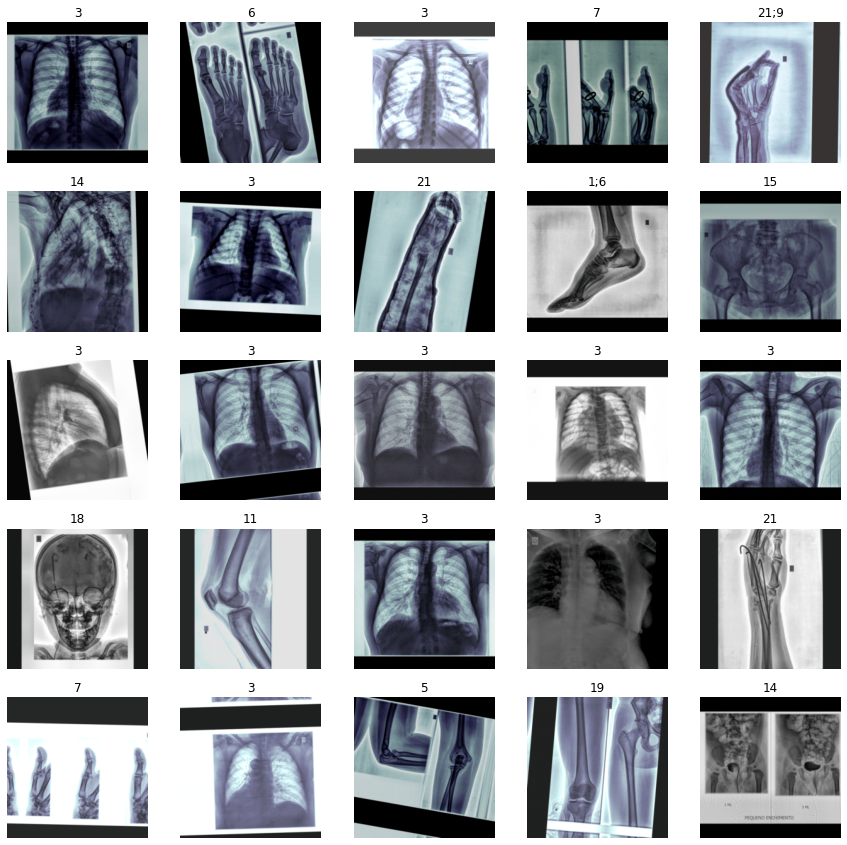

In [29]:
dls.train.show_batch(max_n=25)


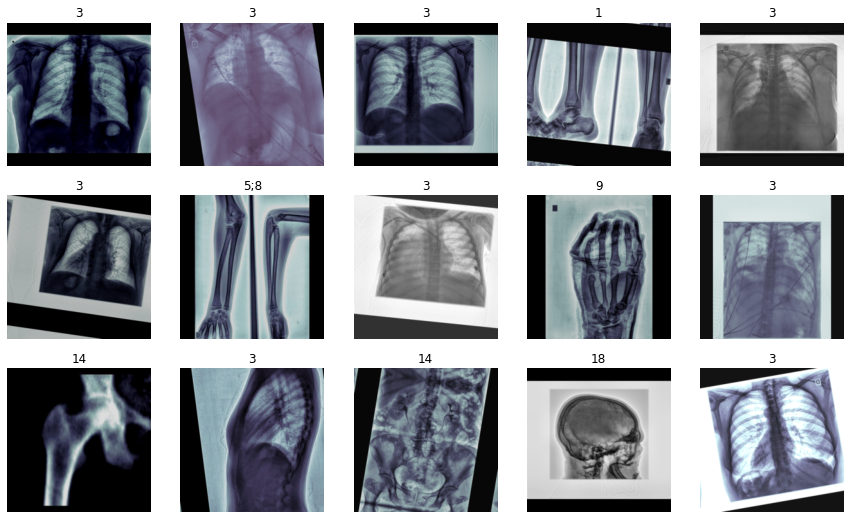

In [30]:
dls.valid.show_batch(max_n=15)

In [31]:
#Чтобы корректно считалась метрика F1Score, взял с public kernel этого Kaggle-соревнования.
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_micro = F1ScoreMulti(thresh=0.5, average='micro')
f1_weighted = F1ScoreMulti(thresh=0.5, average='weighted')



In [32]:
learn = vision_learner(dls, resnet50, 
                    metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples, f1_micro, f1_weighted]
                      )

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

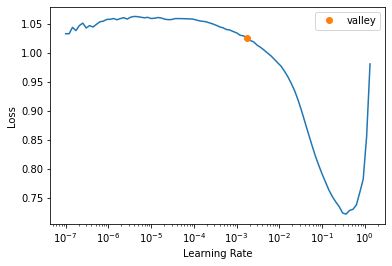

In [33]:
lr = learn.lr_find() 

In [ ]:
learn.fine_tune(60, lr[0])

epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,f1_score,f1_score,time
0,0.979848,0.727346,0.589206,0.151108,0.191819,0.184607,0.447009,01:59


epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,f1_score,f1_score,time
0,0.854897,0.660312,0.622609,0.168453,0.210083,0.198609,0.490548,01:02
1,0.832971,0.634475,0.644485,0.174020,0.217457,0.207360,0.493687,01:04
2,0.809390,0.607028,0.663217,0.180439,0.230715,0.217352,0.496702,01:04
3,0.784441,0.578707,0.699764,0.200463,0.262335,0.241060,0.524993,01:03
4,0.760691,0.552209,0.736704,0.212244,0.287503,0.261029,0.537073,01:03
5,0.731198,0.517779,0.777443,0.242672,0.335240,0.298224,0.568265,01:01
6,0.696395,0.479242,0.828006,0.272536,0.440546,0.354156,0.597438,01:00
7,0.657731,0.432815,0.876605,0.335301,0.519830,0.435252,0.651826,01:04
8,0.608230,0.366117,0.940005,0.445293,0.682503,0.604491,0.727770,01:03
9,0.550044,0.290840,0.970658,0.561552,0.811720,0.757050,0.798724,01:03


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


,target,predicted,probabilities,loss
0,14,13;20,"TensorBase([1.5522e-04, 2.6824e-04, 4.6345e-05, 2.5170e-04, 1.1778e-04, 9.9867e-01,\n 9.8426e-04, 2.2048e-04, 1.8536e-04, 2.0684e-04, 1.1403e-04, 2.2753e-04,\n 4.9670e-04, 9.9916e-01, 5.5430e-04, 6.1553e-05, 1.3252e-04, 2.9001e-04,\n 2.4051e-04, 5.2401e-04, 2.4792e-04, 3.0899e-04])",1.1170159578323364
1,11,6,"TensorBase([1.5353e-04, 2.3152e-04, 2.3333e-04, 9.7213e-05, 1.8315e-04, 2.9413e-04,\n 6.5013e-03, 4.5817e-04, 7.2198e-05, 7.3639e-05, 1.1696e-04, 9.1911e-05,\n 4.2819e-04, 1.7549e-04, 5.9378e-04, 2.0786e-04, 1.9435e-04, 5.4544e-04,\n 9.9781e-01, 9.4884e-05, 3.3180e-04, 1.2841e-04])",0.8078662157058716
2,14,3,"TensorBase([4.0651e-04, 5.4892e-04, 3.1189e-04, 4.4117e-04, 2.7483e-04, 6.1681e-04,\n 4.0234e-04, 1.5784e-03, 1.0780e-03, 1.3838e-04, 2.0224e-04, 3.7486e-04,\n 1.7805e-03, 1.5649e-03, 4.5150e-04, 9.9105e-01, 1.8359e-03, 3.4210e-04,\n 8.4317e-04, 2.7684e-04, 1.7928e-03, 1.3852e-04])",0.6898623704910278
3,10,15,"TensorBase([1.5368e-05, 1.7170e-05, 2.6764e-03, 2.5787e-04, 1.2661e-05, 3.7214e-04,\n 1.3221e-05, 9.8864e-01, 3.9625e-06, 2.8018e-05, 1.8679e-05, 3.8036e-04,\n 5.5873e-06, 2.2129e-04, 8.9269e-05, 3.9506e-05, 1.2662e-05, 6.7429e-05,\n 4.7971e-05, 9.5633e-06, 5.0671e-05, 1.6375e-04])",0.6441553235054016
4,21;9,9,"TensorBase([1.5649e-04, 5.8470e-02, 4.5692e-05, 6.3132e-05, 4.1333e-04, 2.8220e-04,\n 4.0448e-04, 1.0138e-04, 6.9495e-05, 6.6381e-05, 2.5233e-04, 2.2356e-05,\n 6.3206e-05, 3.4273e-04, 2.1746e-02, 3.4481e-03, 3.8776e-04, 3.3649e-05,\n 2.5831e-02, 1.8579e-04, 2.4410e-05, 9.2732e-01])",0.6394892930984497
5,3,2,"TensorBase([4.5929e-04, 2.1342e-04, 7.6946e-05, 5.2082e-05, 1.0300e-04, 8.3730e-04,\n 4.6889e-04, 2.8194e-04, 7.5829e-04, 4.9612e-05, 6.5822e-05, 1.1080e-04,\n 9.9859e-01, 2.5988e-03, 2.3675e-03, 1.5189e-04, 7.7591e-04, 2.4272e-04,\n 3.7676e-04, 1.0705e-04, 5.8589e-05, 8.6613e-05])",0.6163620948791504
6,0,13,"TensorBase([9.4118e-02, 4.2632e-04, 4.0229e-04, 3.7512e-04, 2.3018e-04, 9.4274e-01,\n 6.3939e-04, 9.3894e-05, 8.7182e-05, 1.0904e-04, 3.0366e-04, 2.1697e-04,\n 1.7775e-03, 2.2446e-02, 1.6259e-04, 1.9100e-04, 4.6467e-04, 2.2142e-04,\n 6.2313e-04, 9.8655e-05, 1.7612e-04, 3.4719e-04])",0.5072326064109802
7,21,1,"TensorBase([5.6150e-05, 9.9920e-01, 6.6680e-05, 2.1087e-04, 4.2365e-05, 4.4877e-04,\n 6.8296e-05, 1.0725e-03, 2.0126e-04, 9.4219e-05, 3.9991e-05, 6.5524e-05,\n 1.9661e-05, 1.0961e-04, 1.8092e-03, 7.2432e-05, 5.7237e-05, 1.1807e-04,\n 1.7870e-03, 4.3061e-05, 7.2305e-05, 4.3906e-05])",0.45323053002357483
8,3;7,7,"TensorBase([2.0251e-05, 5.2151e-06, 1.0045e-05, 2.3401e-05, 5.6107e-06, 2.3971e-05,\n 2.3506e-04, 4.6571e-05, 1.0014e-03, 3.9932e-05, 9.0190e-05, 2.7931e-04,\n 1.8310e-05, 5.1141e-05, 1.2154e-01, 7.5148e-05, 4.8790e-05, 1.2920e-05,\n 2.2658e-05, 9.9734e-01, 5.4566e-04, 1.6007e-03])",0.4363264739513397
9,21,1,"TensorBase([5.5267e-05, 9.9331e-01, 2.9739e-05, 1.6435e-04, 2.6285e-05, 3.1793e-04,\n 1.7776e-04, 1.8531e-04, 2.0631e-04, 4.5701e-05, 6.3739e-05, 2.2821e-05,\n 6.0973e-05, 8.9073e-05, 3.6998e-02, 2.2516e-05, 6.0113e-05, 1.6733e-05,\n 9.6443e-04, 2.4071e-05, 5.6584e-05, 4.0106e-05])",0.40225571393966675


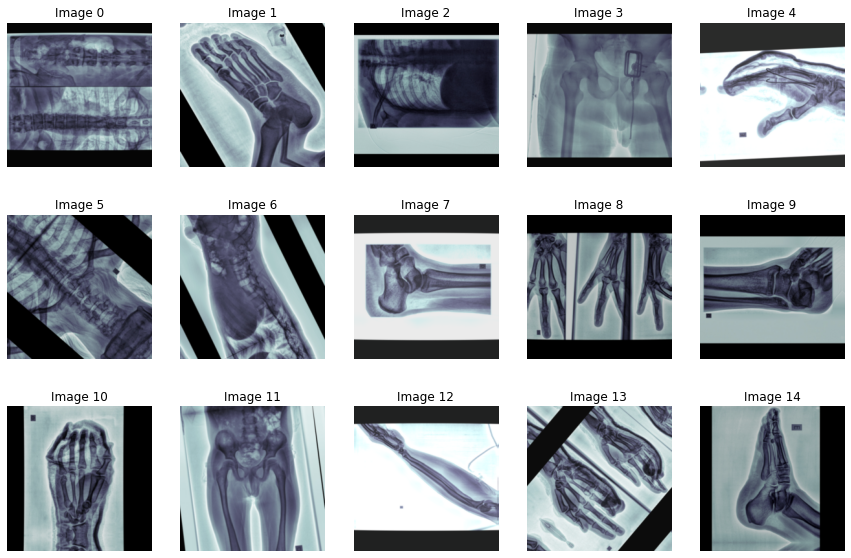

In [ ]:
#посмотрим топ-ошибок.Вернее не посмотрим, потому что -вероятно из за деления на ноль при подсчете F1score - некоторые классы не предсказывает.
#Надо пробовать делать valid_pct=0 и указывать для валидации данные из другой папки, которая "тест".
#А все содержимое папки трейн загонять на обучение полностью.Или делать больше данных через аугментацию.
#либо, как тут написано, задавать  параметр zero_division  в sklearn.metrics.classification_report
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(15, figsize=(15, 10))

In [ ]:
#learn.predict("../input/1.2.826.0.1.3680043.8.498.10000428974990117276582711948006105617.jpg")

In [ ]:
learn.export()
learn.save('Albumentations#2_DeepF_model') 

Path('/content/drive/MyDrive/train_xray/models/1_model.pth')